In [2]:
import pandas as pd
import hopsworks
import joblib
import datetime
from PIL import Image
from datetime import datetime
#import dataframe_image as dfi
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
import seaborn as sns
import requests
import os
from dotenv import load_dotenv

In [3]:
load_dotenv()
api_key = os.getenv("HOPSWORKS_API_KEY")

In [4]:
project = hopsworks.login(api_key_value=api_key, project="DD2223_lab1")
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/206996
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
mr = project.get_model_registry()
model = mr.get_model("winequality_model", version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/winequality_model.pkl")

Connected. Call `.close()` to terminate connection gracefully.

In [6]:
feature_view = fs.get_feature_view(name="wine_quality", version=1)
batch_data = feature_view.get_batch_data()
batch_data

Finished: Reading data from Hopsworks, using ArrowFlight (1.06s) 


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,sulphates,alcohol
0,6.000000,0.300000,0.440000,1.500000,0.046000,15.000000,182.000000,0.994550,0.520000,10.400000
1,6.700000,0.160000,0.640000,2.100000,0.059000,24.000000,52.000000,0.994940,0.710000,11.200000
2,5.800000,0.250000,0.240000,13.300000,0.044000,41.000000,137.000000,0.997200,0.420000,9.500000
3,6.800000,0.370000,0.280000,4.000000,0.030000,29.000000,79.000000,0.990000,0.460000,12.400000
4,6.400000,0.180000,0.740000,11.900000,0.046000,54.000000,168.000000,0.997800,0.680000,10.100000
...,...,...,...,...,...,...,...,...,...,...
5340,9.224999,0.715040,0.030188,1.593261,0.140201,21.893136,111.642616,0.998551,0.467593,12.487485
5341,7.475973,0.200610,0.250024,2.732909,0.063825,10.374772,224.148340,0.997005,0.355702,11.927322
5342,9.853002,0.567981,0.467518,1.716121,0.182976,75.829273,278.944598,0.992833,0.509459,9.427214
5343,7.086754,0.095832,0.266382,14.440467,0.060845,66.209193,144.291661,0.996702,0.510777,8.591764


In [7]:
y_pred = model.predict(batch_data)
#print(y_pred)
offset = 1
wine = y_pred[y_pred.size-offset]
print("Predicted wine quality: " + str(int(wine) + 3))

Predicted wine quality: 6


In [8]:
wine_latest="latest_wine.txt"
if os.path.exists(wine_latest):
    print(f"The file 'wine_latest' already exists. Overwriting...")

# Open the file in write mode, this will create the file if it doesn't exist
with open(wine_latest, 'w') as file:
    file.write(str(int(wine) + 3))

dataset_api = project.get_dataset_api()    
dataset_api.upload("./latest_wine.txt", "Resources/images", overwrite=True)

The file 'wine_latest' already exists. Overwriting...


Uploading: 0.000%|          | 0/1 elapsed<00:00 remaining<?

'Resources/images/latest_wine.txt'

In [9]:
print(y_pred)

[2 3 2 ... 2 5 3]


In [10]:
wine_fg = fs.get_feature_group(name="wine_quality", version=1)
df = wine_fg.read() 
#print(df)
label = df.iloc[-offset]["quality"]
print("Actual wine quality: " + str(int(label)))

wine_actual="actual_wine.txt"
if os.path.exists(wine_latest):
    print(f"The file 'wine_latest' already exists. Overwriting...")

# Open the file in write mode, this will create the file if it doesn't exist
with open(wine_actual, 'w') as file:
    file.write(str(int(label)))

dataset_api.upload("./actual_wine.txt", "Resources/images", overwrite=True)

Finished: Reading data from Hopsworks, using ArrowFlight (1.17s) 
Actual wine quality: 5
The file 'wine_latest' already exists. Overwriting...


Uploading: 0.000%|          | 0/1 elapsed<00:00 remaining<?

'Resources/images/actual_wine.txt'

In [11]:
monitor_fg = fs.get_or_create_feature_group(name="wine_quality_predictions",
                                            version=1,
                                            primary_key=["datetime"],
                                            description="Wine Quality Prediction/Outcome Monitoring"
                                            )

now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")

In [12]:
data = {
    'prediction': [int(wine) + 3],
    'label': [int(label)],
    'datetime': [now],
    }
data

{'prediction': [6], 'label': [5], 'datetime': ['11/21/2023, 00:17:22']}

In [13]:
monitor_df = pd.DataFrame(data)
monitor_fg.insert(monitor_df, write_options={"wait_for_job" : False})

history_df = monitor_fg.read()
# Add our prediction to the history, as the history_df won't have it - 
# the insertion was done asynchronously, so it will take ~1 min to land on App
history_df = pd.concat([history_df, monitor_df])

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: wine_quality_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/206996/jobs/named/wine_quality_predictions_1_offline_fg_materialization/executions
Finished: Reading data from Hopsworks, using ArrowFlight (0.70s) 


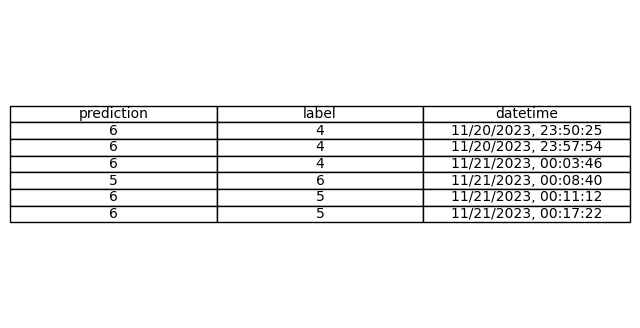

In [14]:
#import dataframe_image as dfi
import matplotlib.pyplot as plt
df_recent = history_df.tail(6)
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_recent.values, colLabels=df_recent.columns, cellLoc = 'center', loc='center')

# Save the plot as an image
plt.savefig('./df_recent.png')

# Optionally, you can also display the plot
plt.show()
#dfi.export(df_recent, './df_recent.png', table_conversion = 'matplotlib')


In [15]:
dataset_api.upload("./df_recent.png", "Resources/images", overwrite=True)

Uploading: 0.000%|          | 0/24523 elapsed<00:00 remaining<?

'Resources/images/df_recent.png'

In [16]:
predictions = history_df[['prediction']]
labels = history_df[['label']]
predictions.value_counts()

prediction
6             13
5              9
Name: count, dtype: int64

In [17]:
predictions = history_df[['prediction']]
labels = history_df[['label']]

# Only create the confusion matrix when our wine_quality_predictions feature group has examples of all 7 qualities
print("Number of different wine quality predictions to date: " + str(predictions.value_counts().count()))

Number of different wine quality predictions to date: 2


In [21]:
predictions.value_counts()

prediction
6             13
5              9
Name: count, dtype: int64

Uploading: 0.000%|          | 0/17656 elapsed<00:00 remaining<?

'Resources/images/wine_confusion_matrix.png'

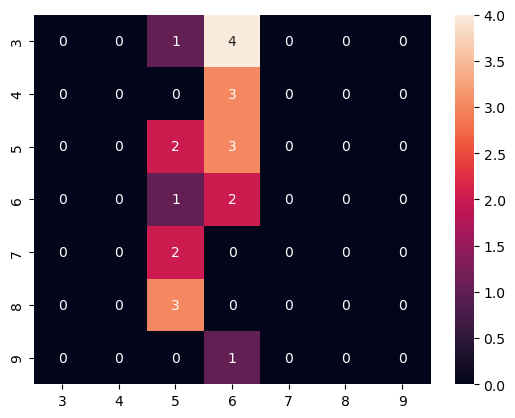

In [22]:

#if predictions.value_counts().count() == 7:
results = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(results, [3, 4, 5, 6, 7, 8, 9],
                        [3, 4, 5, 6, 7, 8, 9])

cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()
fig.savefig("./wine_confusion_matrix.png")
dataset_api.upload("./wine_confusion_matrix.png", "Resources/images", overwrite=True)
# else:
#     print("You need 7 different wine quality predictions to create the confusion matrix.")
#     print("Run the batch inference pipeline more times until you get 7 different wine quality predictions") 